# TensorBoard Metrics Analysis

This notebook fetches and plots metrics from a TensorBoard server, allowing for filtering and renaming of experiments.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import io
import urllib.parse

sns.set_style("darkgrid")

In [2]:
def fetch_scalar_data(url, run, tag):
    encoded_run = urllib.parse.quote(run, safe='')
    encoded_tag = urllib.parse.quote(tag, safe='')
    full_url = f"{url}/data/plugin/scalars/scalars?run={encoded_run}&tag={encoded_tag}&format=csv"
    try:
        response = requests.get(full_url)
        response.raise_for_status()
        return pd.read_csv(io.StringIO(response.text))
    except requests.RequestException as e:
        print(f"Failed to fetch data for run '{run}', tag '{tag}': {e}")
        print(f"URL attempted: {full_url}")
        return None

def fetch_runs(url):
    try:
        response = requests.get(f"{url}/data/runs")
        response.raise_for_status()
        runs = response.json()
        # Filter out runs with ".guild" in the name
        filtered_runs = [run for run in runs if ".guild" not in run]
        print(f"Found {len(filtered_runs)} runs after filtering")
        return filtered_runs
    except requests.RequestException as e:
        print(f"Failed to fetch runs: {e}")
        return []

## Set Parameters

Set the TensorBoard URL, metrics to analyze, and output directory.

In [3]:
TENSORBOARD_URL = "http://arch-rog-strix:12345"  # Replace with your TensorBoard URL
METRICS = ["accuracy", "auc", "loss/train", "loss/val"]  # Replace with your desired metrics
OUTPUT_DIR = "plots_experiments"  # Replace with your desired output directory

## Fetch and Rename Runs

In [139]:
runs = fetch_runs(TENSORBOARD_URL)
renamed_runs = {}

# Create a list to hold the ordered runs
ordered_runs = []

# Get user input to order the runs
print("Please provide the order for the runs by entering their indices separated by commas (e.g., 0,2,1):")
for idx, run in enumerate(runs):
    print(f"{idx}: {run}")

order_input = input("Enter the indices of the runs in the desired order: ")
order_indices = [int(i) for i in order_input.split(",")]

# Build the ordered list based on the user's input
for index in order_indices:
    if index < len(runs):
        ordered_runs.append(runs[index])
    else:
        print(f"Index {index} is out of range. Please provide valid indices.")

# Rename the ordered runs
for run in ordered_runs:
    new_name = input(f"Enter new name for run '{run}' (press Enter to keep current name): ").strip()
    renamed_runs[run] = new_name if new_name else run

print("Renamed runs:", renamed_runs)

Found 3 runs after filtering
Please provide the order for the runs by entering their indices separated by commas (e.g., 0,2,1):
0: 27d574db scl:train 2024-09-16 18:52:56 SOTA2021-like - AdaFace baseline/exp/lightning_logs/version_0
1: 843e338a scl:train 2024-07-06 23:12:03 SOTA2021-like + Sampler + HCLV4 (FTPos, no +1)/exp/lightning_logs/version_0
2: b8c1c5ed scl:train 2024-09-17 13:21:27 SOTA2021-like - AdaFace baseline (shuffle train, no bias)/exp/lightning_logs/version_0


Enter the indices of the runs in the desired order:  0,2,1
Enter new name for run '27d574db scl:train 2024-09-16 18:52:56 SOTA2021-like - AdaFace baseline/exp/lightning_logs/version_0' (press Enter to keep current name):  AdaFace (sequential samples)
Enter new name for run 'b8c1c5ed scl:train 2024-09-17 13:21:27 SOTA2021-like - AdaFace baseline (shuffle train, no bias)/exp/lightning_logs/version_0' (press Enter to keep current name):  AdaFace (random samples)
Enter new name for run '843e338a scl:train 2024-07-06 23:12:03 SOTA2021-like + Sampler + HCLV4 (FTPos, no +1)/exp/lightning_logs/version_0' (press Enter to keep current name):  Proposed method


Renamed runs: {'27d574db scl:train 2024-09-16 18:52:56 SOTA2021-like - AdaFace baseline/exp/lightning_logs/version_0': 'AdaFace (sequential samples)', 'b8c1c5ed scl:train 2024-09-17 13:21:27 SOTA2021-like - AdaFace baseline (shuffle train, no bias)/exp/lightning_logs/version_0': 'AdaFace (random samples)', '843e338a scl:train 2024-07-06 23:12:03 SOTA2021-like + Sampler + HCLV4 (FTPos, no +1)/exp/lightning_logs/version_0': 'Proposed method'}


## Load Data

In [140]:
data = []
for original_run, new_run_name in renamed_runs.items():
    for metric in METRICS:
        metric_data = fetch_scalar_data(TENSORBOARD_URL, original_run, metric)
        if metric_data is not None:
            print(f"{metric} fetched for run {new_run_name}")
            metric_data['run'] = new_run_name
            metric_data['metric'] = metric
            data.append(metric_data)
        else:
            print(f"No data for {metric} in run {new_run_name}")

if not data:
    print("No data was successfully fetched.")
else:
    df = pd.concat(data, ignore_index=True)
    print(df.head())

accuracy fetched for run AdaFace (sequential samples)
auc fetched for run AdaFace (sequential samples)
loss/train fetched for run AdaFace (sequential samples)
loss/val fetched for run AdaFace (sequential samples)
accuracy fetched for run AdaFace (random samples)
auc fetched for run AdaFace (random samples)
loss/train fetched for run AdaFace (random samples)
loss/val fetched for run AdaFace (random samples)
accuracy fetched for run Proposed method
auc fetched for run Proposed method
loss/train fetched for run Proposed method
loss/val fetched for run Proposed method
      Wall time  Step     Value                           run    metric
0  1.726524e+09    49  0.730954  AdaFace (sequential samples)  accuracy
1  1.726524e+09    99  0.740577  AdaFace (sequential samples)  accuracy
2  1.726524e+09   149  0.751804  AdaFace (sequential samples)  accuracy
3  1.726524e+09   199  0.760826  AdaFace (sequential samples)  accuracy
4  1.726524e+09   249  0.767241  AdaFace (sequential samples)  accura

## Plot Metrics

In [137]:
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

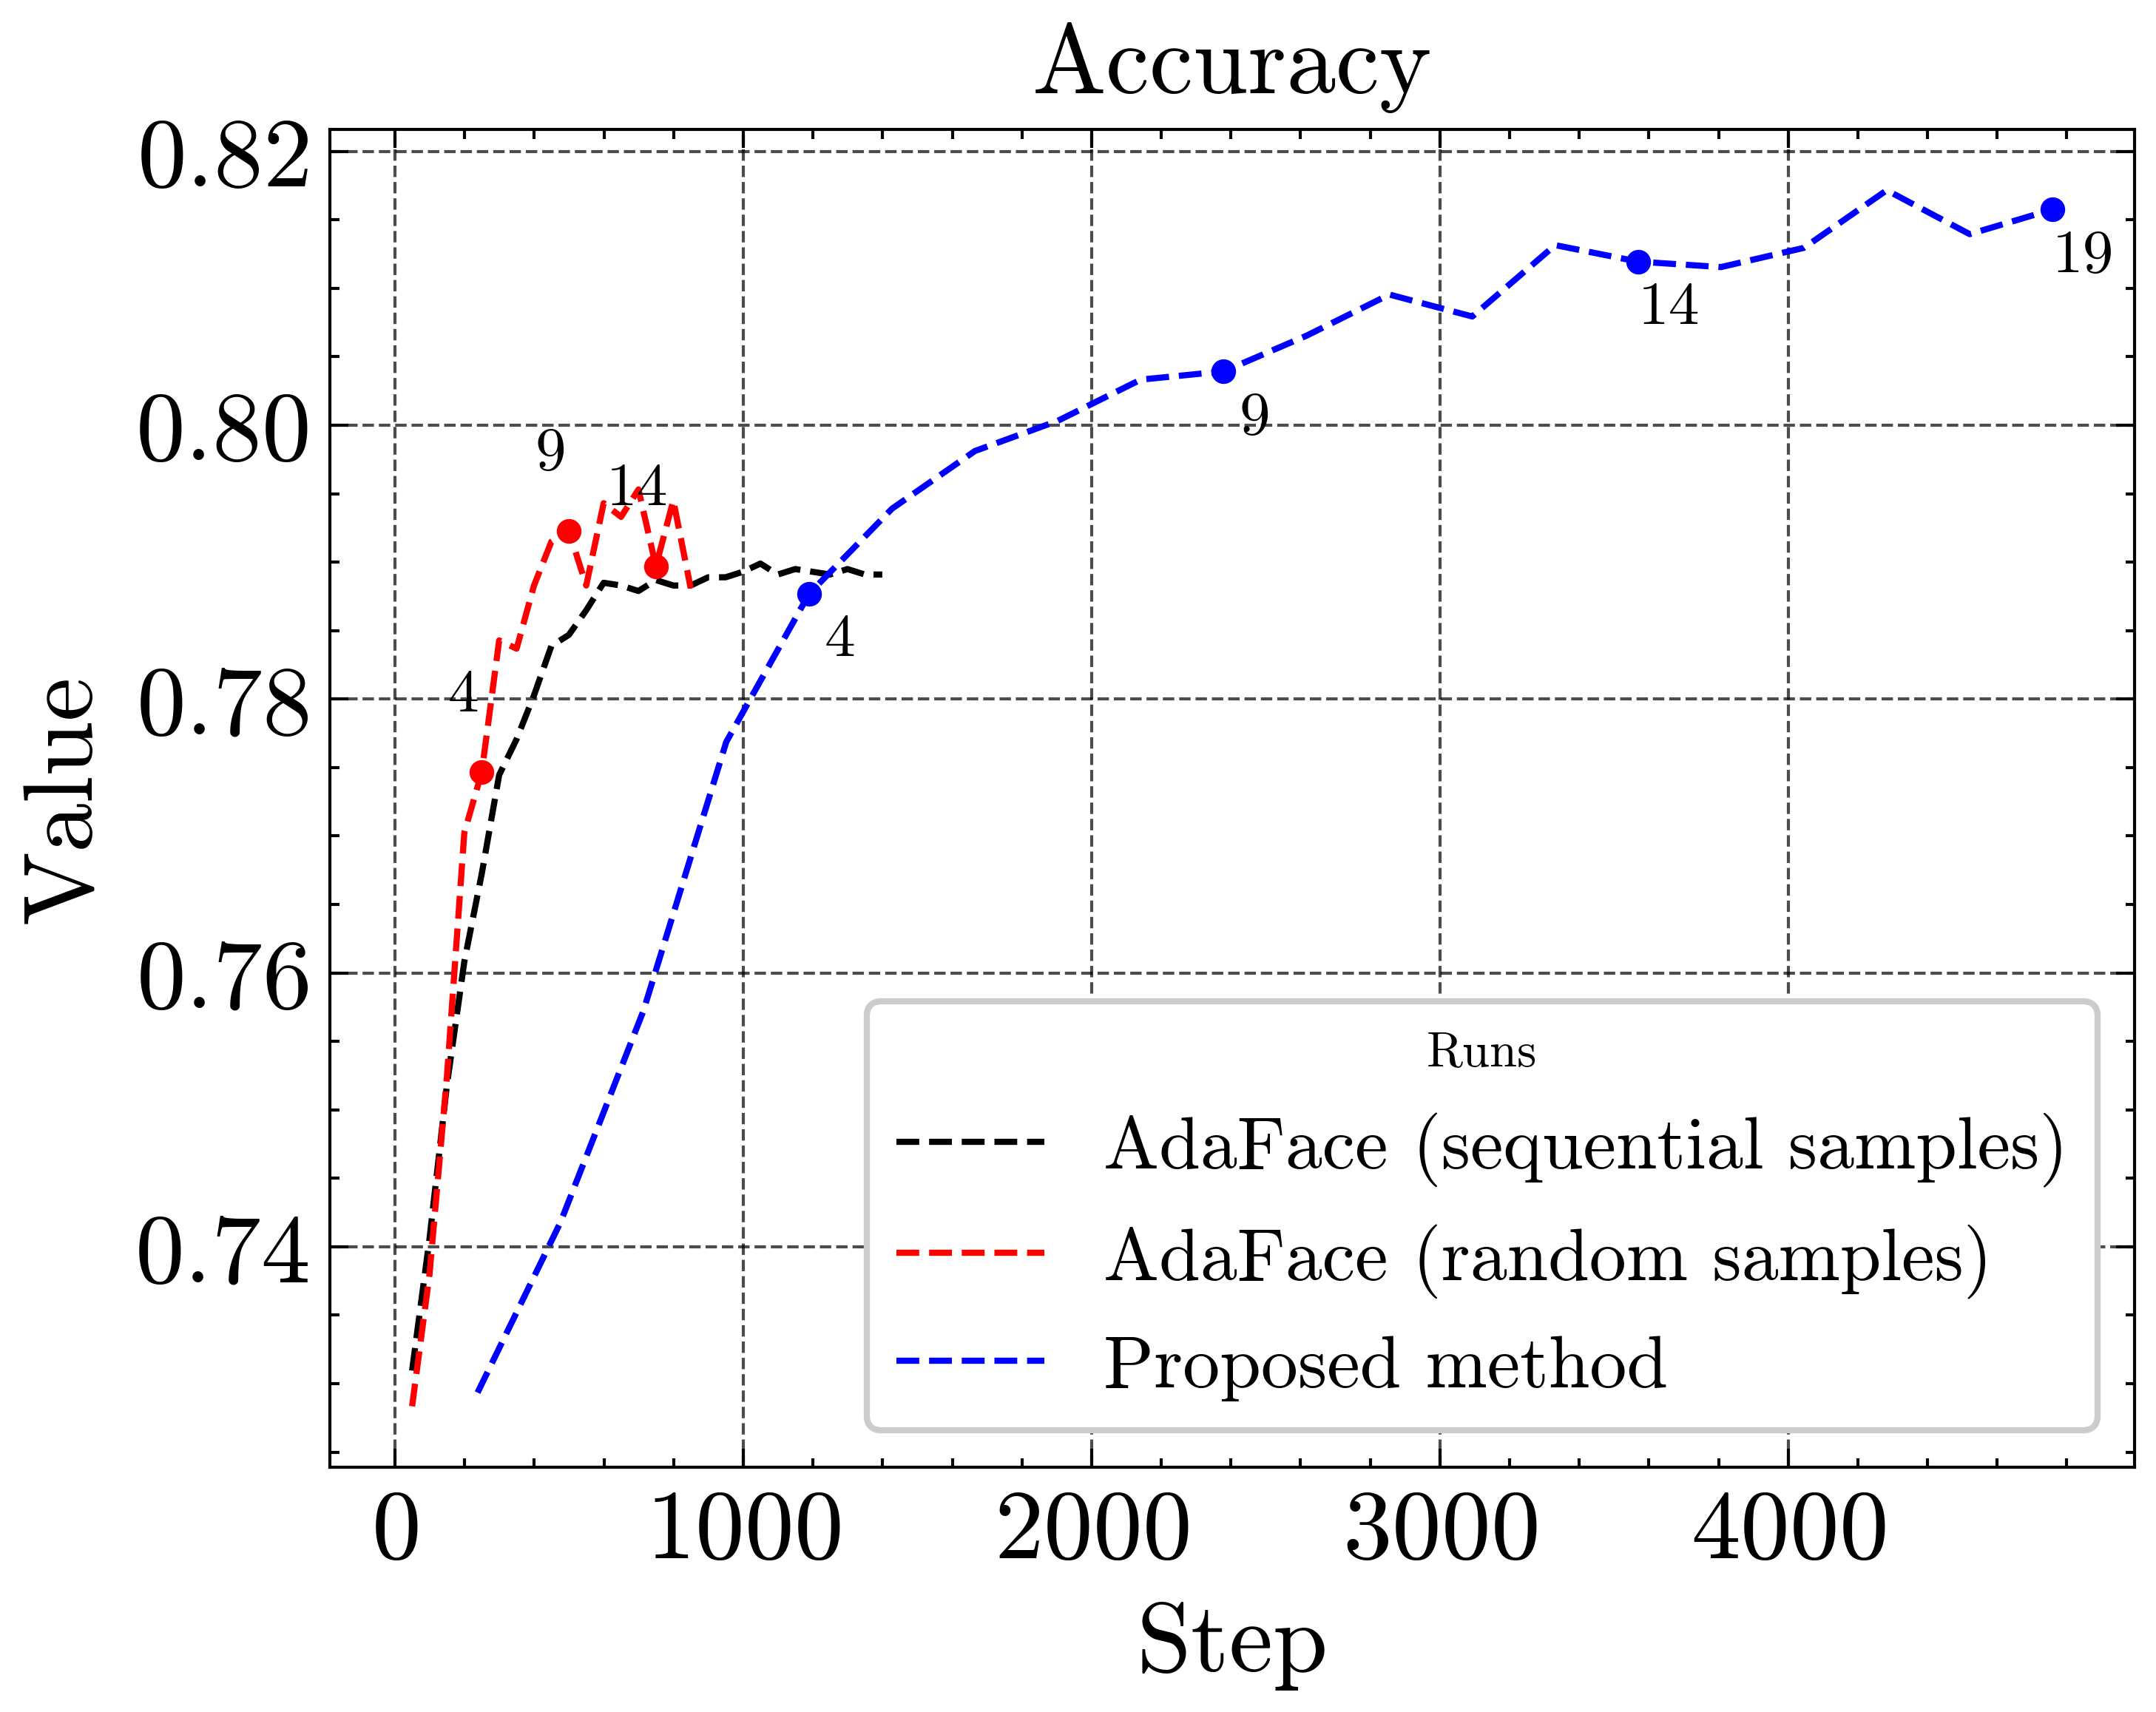

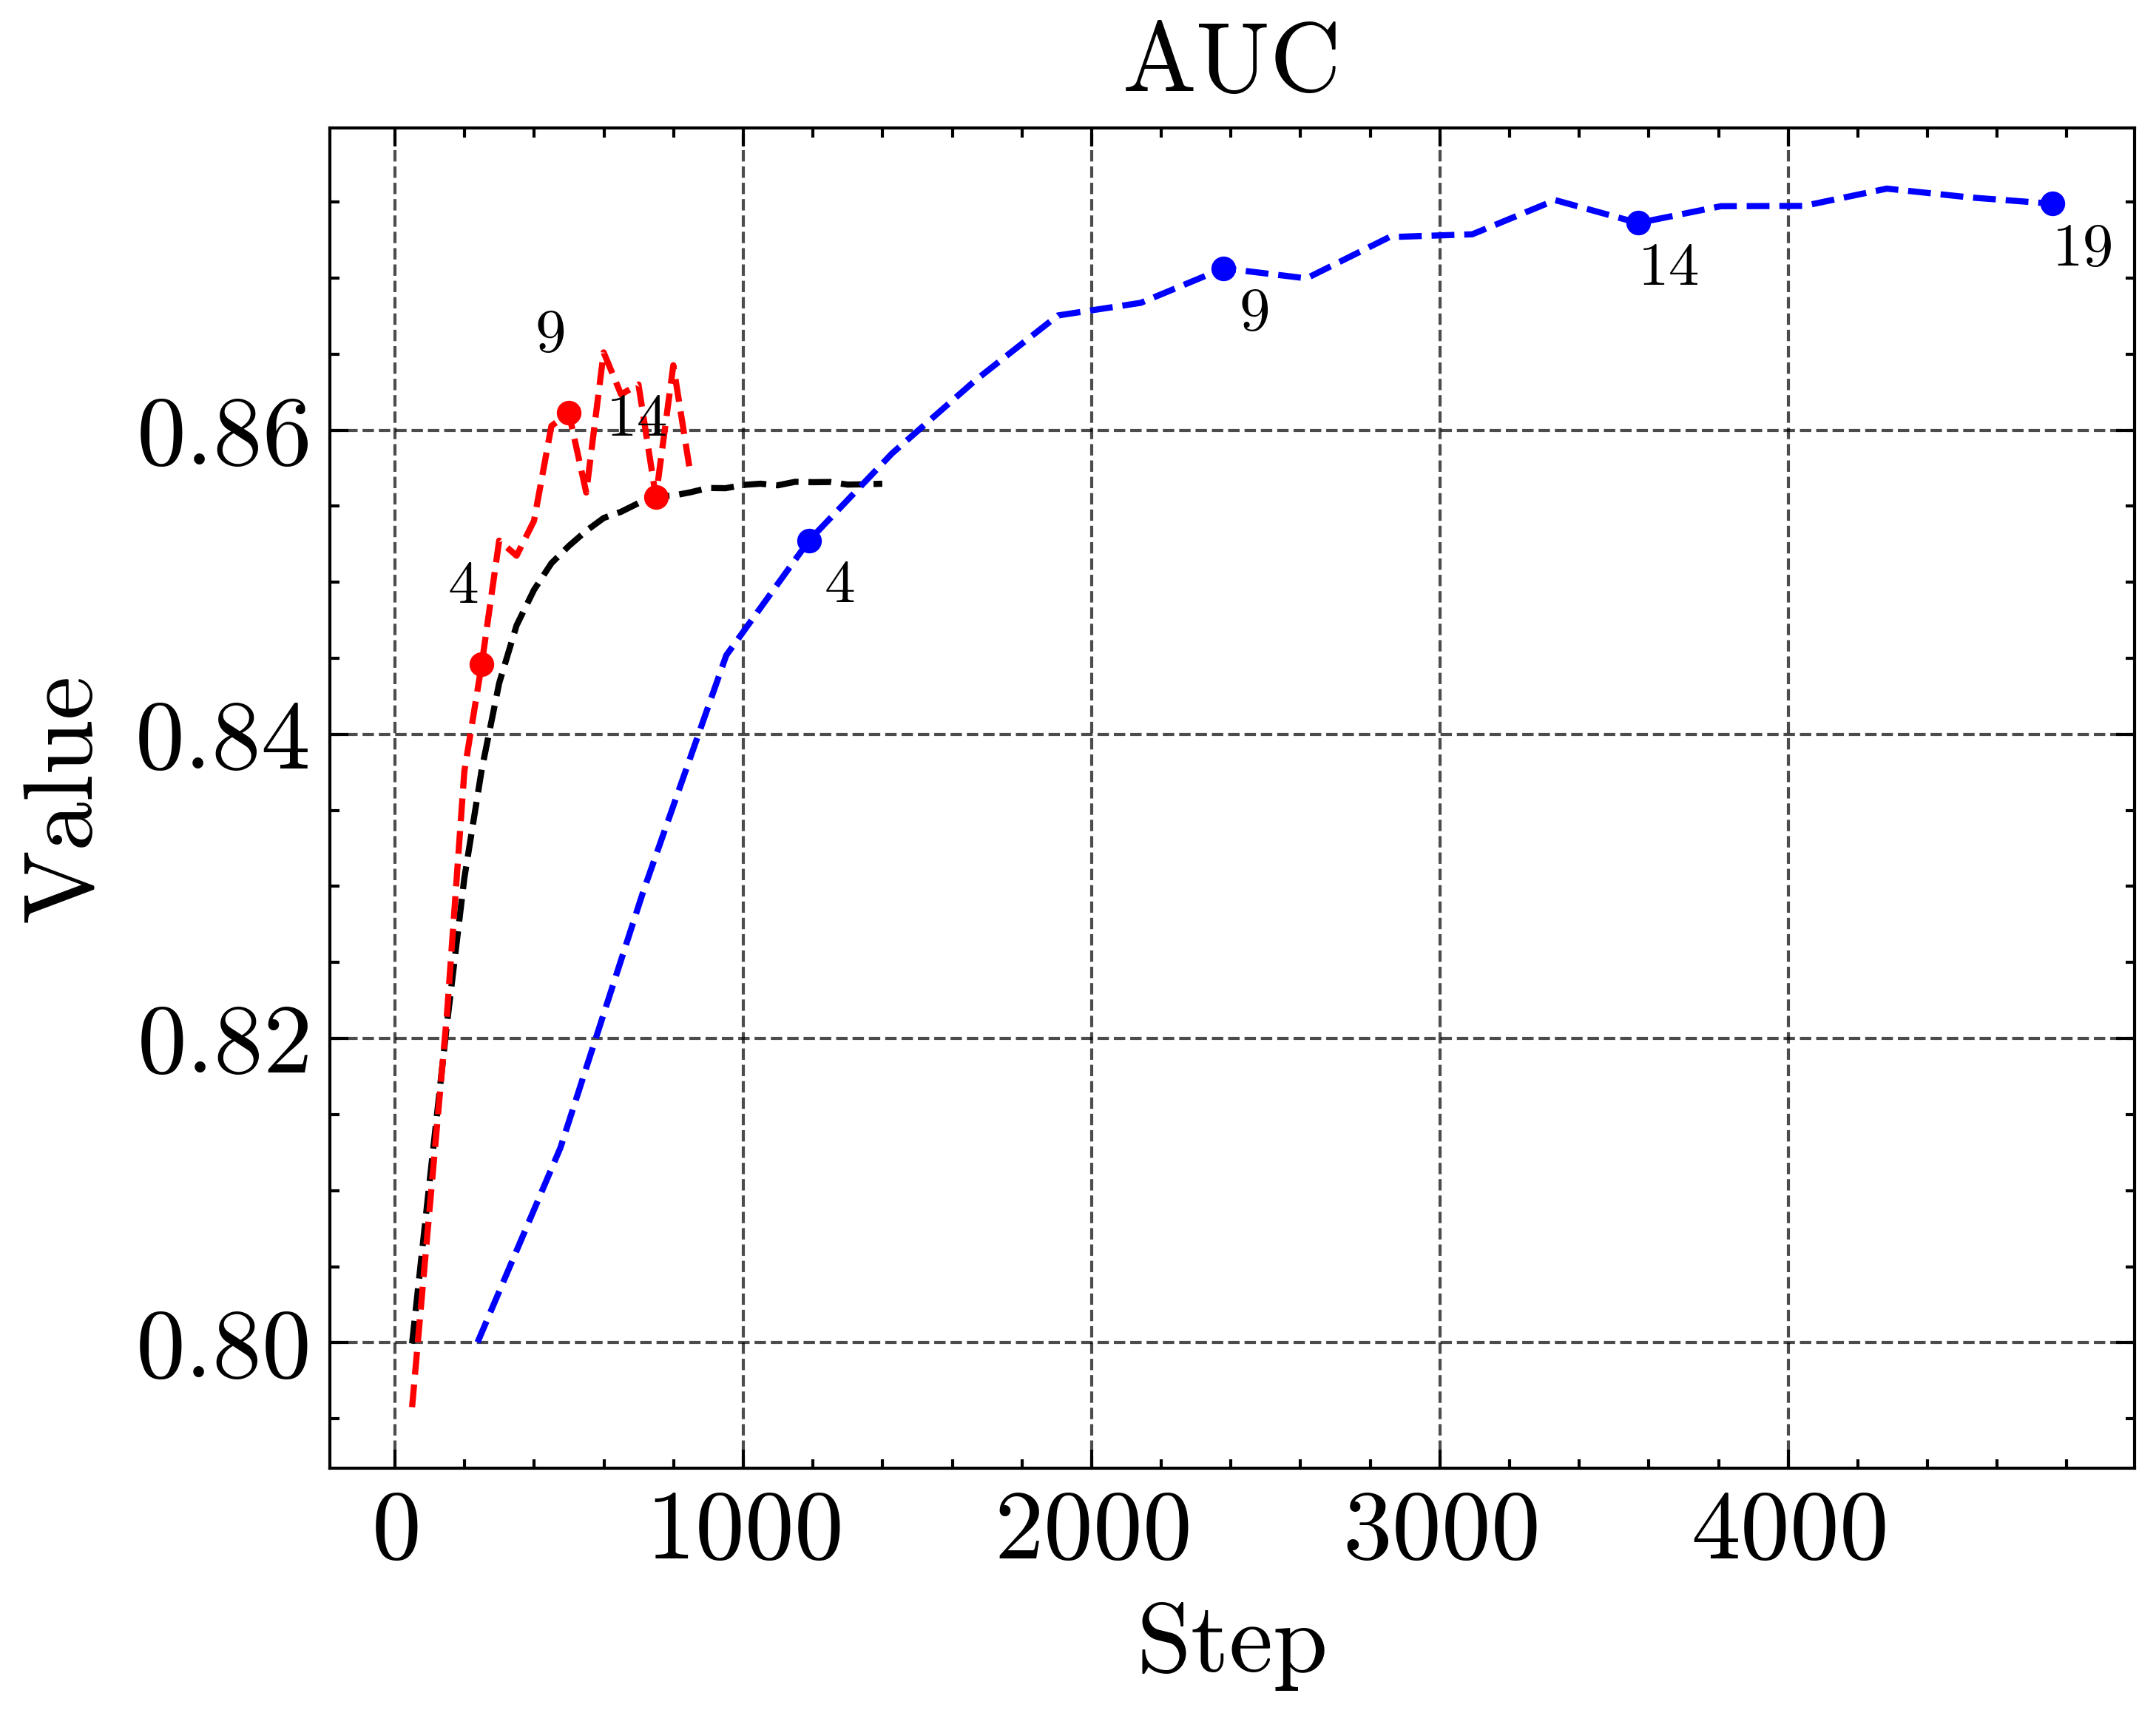

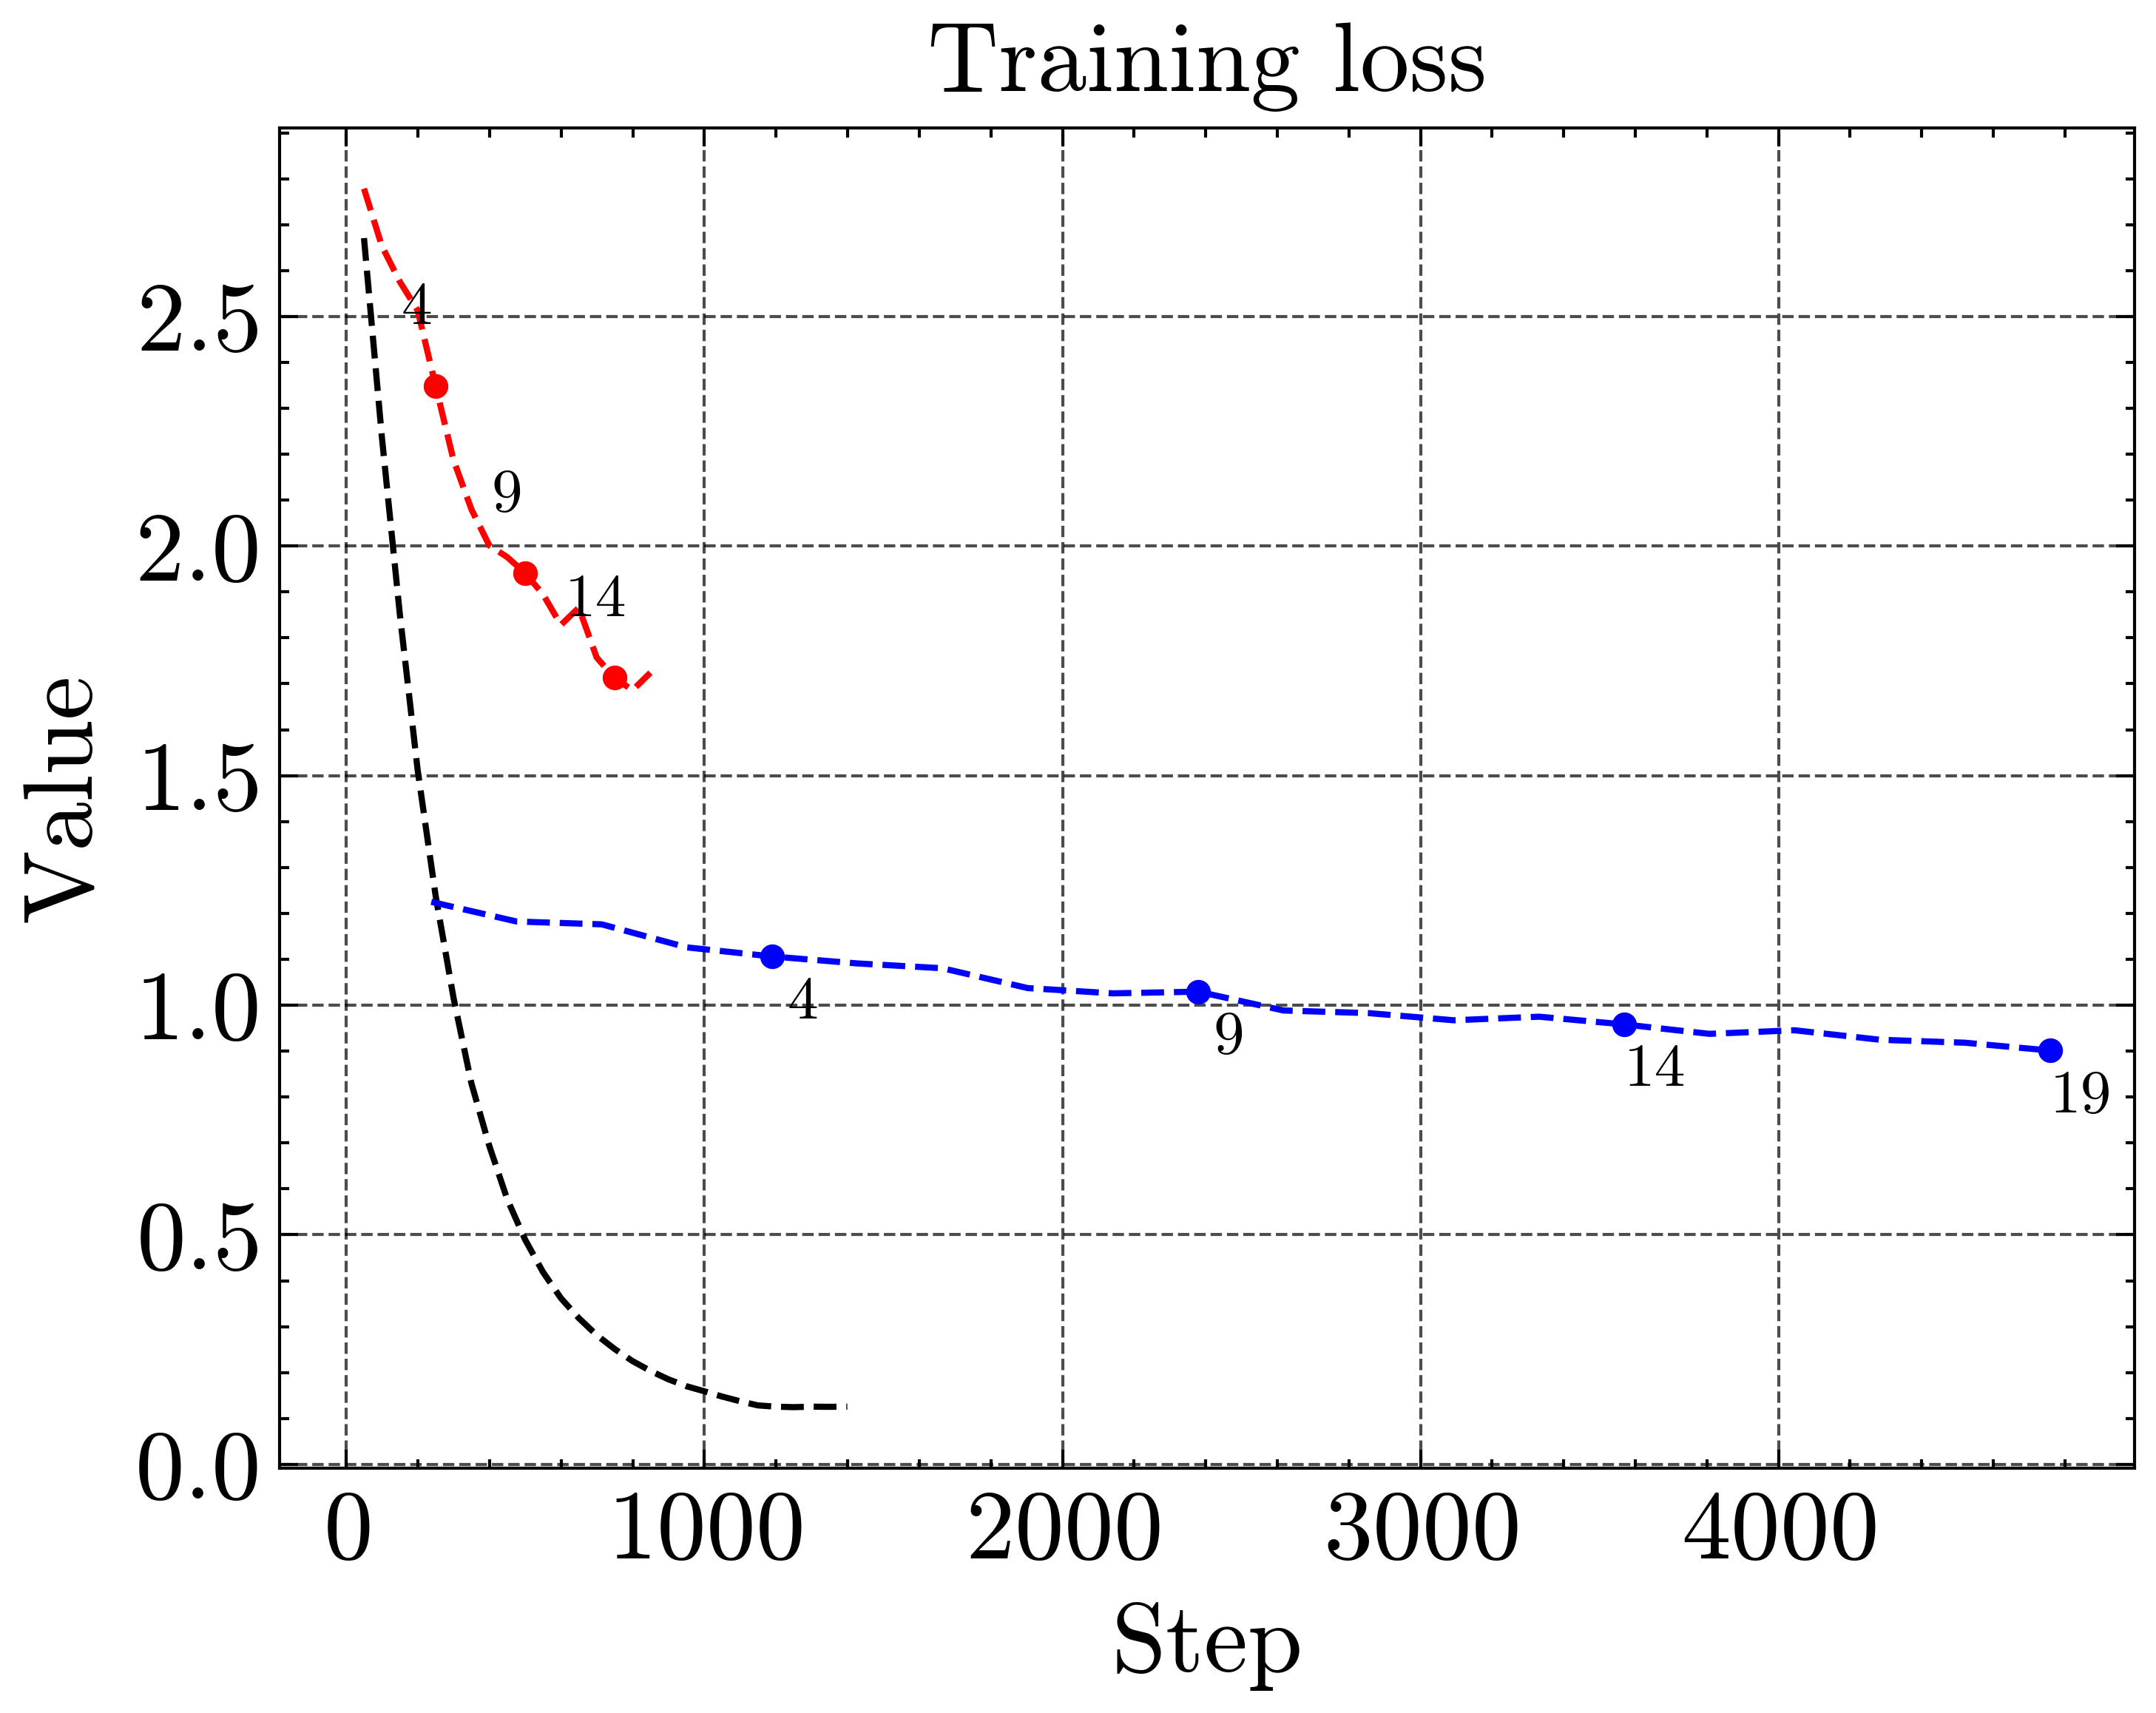

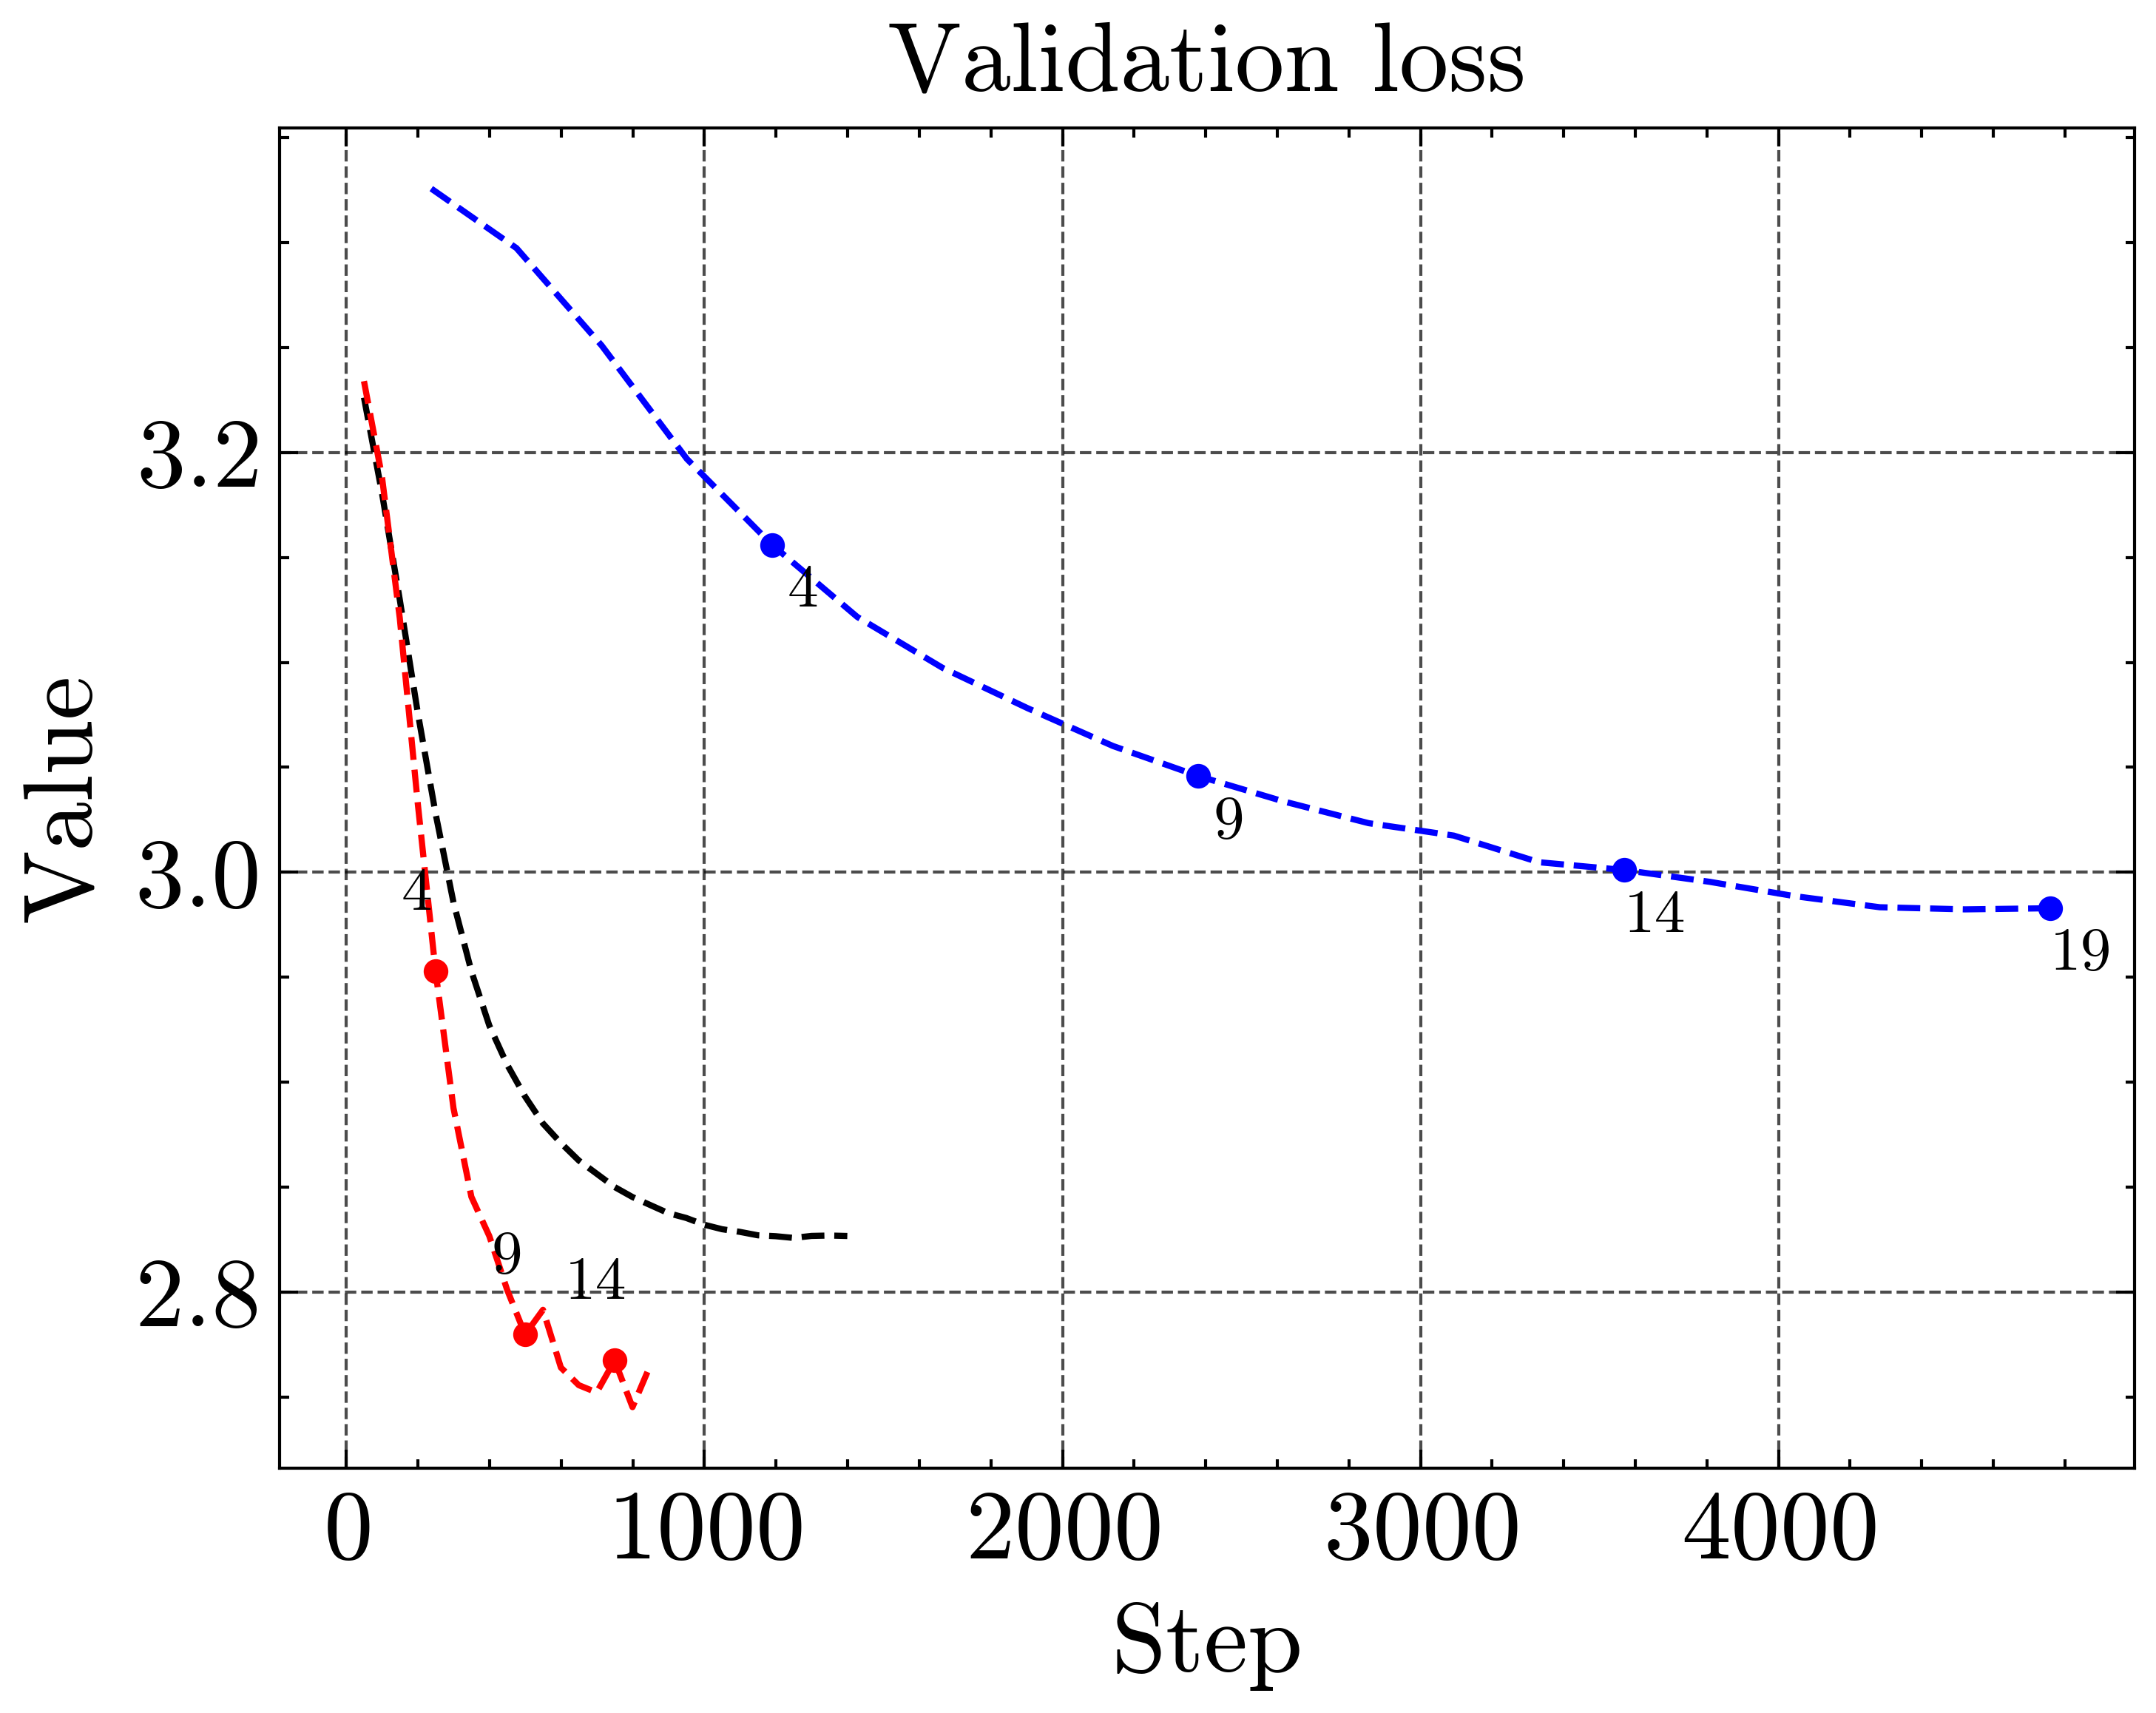

In [142]:
import scienceplots
import seaborn
sns.reset_defaults()
plt.style.use(["science", "ieee", "grid", "no-latex"])

MARK_X_EPOCHS = 5
title_mappings = {"auc": "AUC", "accuracy": "Accuracy", "loss/val": "Validation loss", "loss/train": "Training loss"}

for idx, metric in enumerate(METRICS):
    plt.figure(figsize=(5, 4))
    metric_data = df[df['metric'] == metric]

    if metric_data.empty:
        print(f"No data available for metric: {metric}")
        continue

    for run in metric_data['run'].unique():
        run_data = metric_data[metric_data['run'] == run]
        line, = plt.plot(run_data['Step'], run_data['Value'], '--', label=run)

        # Annotate the plot at the specified intervals
        for step in run_data['Step']:
            step_value = run_data[run_data['Step'] == step]['Value'].values[0]
            xy = (step, step_value)
            # Get the color of the line
            line_color = line.get_color()
            if "AdaFace (random samples)" == run:
                if not (step + 1) % (MARK_X_EPOCHS * 50):
                    epoch = (step - 1) // 50
                    # Add a point at the (step, step_value)
                    plt.plot(step, step_value, '.', color=line_color)  # Red circle marker
                    plt.annotate(f'{epoch}', xy=xy,
                                 textcoords="offset points", xytext=(-3, 10), ha='center', color='black', size=10)
            else:
                if not (step + 1) % (MARK_X_EPOCHS * 238):
                    epoch = (step - 1) // 238
                    # Add a point at the (step, step_value)
                    plt.plot(step, step_value, '.', color=line_color)  # Red circle marker
                    plt.annotate(f'{epoch}', xy=xy,
                                 textcoords="offset points", xytext=(5, -10), ha='center', color='black', size=10)

    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase size of major ticks

    plt.title(f"{title_mappings[metric]}", fontsize=16)
    plt.xlabel("Step", fontsize=16)
    plt.ylabel("Value", fontsize=16)
    # Show legend only for the first plot
    if idx == 0:
        plt.legend(title="Runs", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    #now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    metric = metric.replace("/", "_")
    #plt.savefig(f"{OUTPUT_DIR}/{metric}_over_time_{now}.png", dpi=200)
    plt.savefig(f"{OUTPUT_DIR}/{metric}.png")
    plt.show()

## Conclusion

The plots have been saved in the specified output directory. You can find them at: `{OUTPUT_DIR}`